## Exploring forecasting various home price metrics with pytorch
see: 
- https://github.com/jdb78/pytorch-forecasting
- https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html 


In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter('ignore')

# imports for training
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# import dataset, network to train and metric to optimize
from pytorch_forecasting import (
    Baseline,
    TimeSeriesDataSet,
    TemporalFusionTransformer,
    QuantileLoss,
)
from pytorch_forecasting.data import TimeSeriesDataSet, GroupNormalizer, NaNLabelEncoder
import torch

# standard imports
import numpy as np
import pandas as pd

#### Load Data

**load data:** this is pandas dataframe with at least a column for
* the target (what you want to predict)
* the timeseries ID (which should be a unique string to identify each timeseries)
* the time of the observation (which should be a monotonically increasing integer)

In [2]:
# rf_sql = """
# select
# *
# from redfin_county_full
# """
# # NOTE: add filters on SQL query once determined they are needed

# redfin = pd.read_sql(rf_sql, con=conn, parse_dates=["period_start", "period_end"])
# # conn.close()

# redfin = redfin.dropna(subset=["median_sale_price"])
# redfin.head()

In [3]:
data = pd.read_csv("data/nn_monthly_data.csv.gz", parse_dates=["period_begin", "period_end"])
#data.head()

In [4]:
# add time index
data["time_idx"] = data["period_end"].dt.year * 12 + data["period_end"].dt.month
data["time_idx"] -= data["time_idx"].min()
data["month"] = data["period_end"].dt.month.astype(str).astype("category")

In [5]:
cols = [
    "period_end",
    "region_type",
    "region_type_id",
    "is_seasonally_adjusted",
    "property_type_id", # leave property type  
    "state_x",
    "fips",
    "state_y",
    "state_fips",
    "table_id",
    "period_duration",
    "city",
    "state_code",
    "parent_metro_region",
    "parent_metro_region_metro_code",
    "median_ppsf",
    "avg_sale_to_list",
    "last_updated",
    "county"
]



In [6]:
data.drop(columns=cols, inplace=True)
# drop the yoy and mom columns
data.drop(list(data.filter(regex = 'yoy|mom')), axis = 1, inplace = True)

Original Columns 

`Index(['county_fips', 'period_begin', 'period_end', 'period_duration',
       'region_type', 'region_type_id', 'table_id', 'is_seasonally_adjusted',
       'region', 'city', 'state', 'state_code', 'property_type',
       'property_type_id', 'median_sale_price', 'median_sale_price_mom',
       'median_sale_price_yoy', 'median_list_price', 'median_list_price_mom',
       'median_list_price_yoy', 'median_ppsf', 'median_ppsf_mom',
       'median_ppsf_yoy', 'median_list_ppsf', 'median_list_ppsf_mom',
       'median_list_ppsf_yoy', 'homes_sold', 'homes_sold_mom',
       'homes_sold_yoy', 'pending_sales', 'pending_sales_mom',
       'pending_sales_yoy', 'new_listings', 'new_listings_mom',
       'new_listings_yoy', 'inventory', 'inventory_mom', 'inventory_yoy',
       'months_of_supply', 'months_of_supply_mom', 'months_of_supply_yoy',
       'median_dom', 'median_dom_mom', 'median_dom_yoy', 'avg_sale_to_list',
       'avg_sale_to_list_mom', 'avg_sale_to_list_yoy', 'sold_above_list',
       'sold_above_list_mom', 'sold_above_list_yoy', 'price_drops',
       'price_drops_mom', 'price_drops_yoy', 'off_market_in_two_weeks',
       'off_market_in_two_weeks_mom', 'off_market_in_two_weeks_yoy',
       'parent_metro_region', 'parent_metro_region_metro_code', 'last_updated',
       'county', 'date', 'unemployment_rate', 'state_x', 'fips', 'year',
       'state_y', 'state_fips', 'income_tax_low', 'income_tax_high',
       'corp_income_tax_low', 'corp_income_tax_high', 'time_idx', 'month'],
      dtype='object')`

In [7]:
#data.info()
#data.head()

In [8]:
data["county_fips"] = data["county_fips"].astype(str).astype("category")

#### Create Dataset & Dataloaders

In [9]:
# define the dataset, i.e. add metadata to pandas dataframe for the model to understand it
max_encoder_length = 60
max_prediction_length = 12
training_cutoff = data["time_idx"].max() - max_prediction_length  # day for cutoff

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",  # column name of time of observation
    target="median_sale_price",  # column name of target to predict
    group_ids=[
        "county_fips",
        "region",
        "state",
        "property_type",
    ],  # column name(s) for timeseries IDs
    max_encoder_length=max_encoder_length,  # how much history to use
    max_prediction_length=max_prediction_length,  # how far to predict into future
    # covariates static for a timeseries ID
    static_categoricals=["region", "property_type", "state", "county_fips"],
    static_reals=[],
    # covariates known and unknown in the future to inform prediction
    time_varying_known_categoricals=["month"],
    time_varying_known_reals=[
        "year",
        "time_idx",
        "income_tax_low",
        "income_tax_high",
        "corp_income_tax_low",
        "corp_income_tax_high",
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "median_sale_price",
        "median_list_price",
        "median_list_ppsf",
        "homes_sold",
        "pending_sales",
        "new_listings",
        "inventory",
        "months_of_supply",
        "median_dom",
        "sold_above_list",
        "off_market_in_two_weeks",
    ],
    add_relative_time_idx=True,
    allow_missing_timesteps=True,
    categorical_encoders={
        "region": NaNLabelEncoder(add_nan=True),
        "county_fips": NaNLabelEncoder(add_nan=True),
    },
)
# target_normalizer=GroupNormalizer(
#     groups=["agency", "sku"], transformation="softplus"
# ),  # use softplus and normalize by group
# add_target_scales=True,
# add_encoder_length=True,
# )


In [10]:
# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(
    training,
    data,
    predict=True,
    min_prediction_idx=training.index.time.max() + 1,
    stop_randomization=True,
)

In [11]:
# convert datasets to dataloaders for training
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=2
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=2 # double check factor of 10 will work
)

#### Baseline Model for comparison

In [12]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()
# baseline with monthly data = 54858.94140625

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


54858.94140625

#### Find Optimal Learning Rate

In [16]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=32,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=16,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=10,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 225.8k


/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
Finding best initial lr:  13%|█▎        | 13/100 [00:07<00:50,  1.73it/s]/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - con

suggested learning rate: 0.041686938347033554


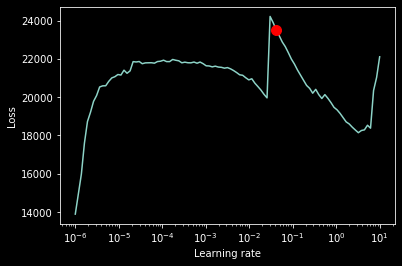

In [17]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

#### Train Model

In [13]:
# configure network and trainer
# create PyTorch Lightning Trainer with early stopping
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=4, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
    gradient_clip_val=0.15,
    limit_train_batches=30,  # 30 batches per epoch
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
# define network to train - the architecture is mostly inferred from the dataset,
# so that only a few hyperparameters have to be set by the user
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=58,
    attention_head_size=4, # play around with this param - can go up to 4 depending on sizeof data 
    dropout=0.1,
    hidden_continuous_size=56,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=0,
    # optimizer parameters
    learning_rate=0.007, #change back to best_tft
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 744.2k


In [15]:
# fit the model on the data - redefine the model with the correct learning rate if necessary
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 212 K 
3  | prescalers                         | ModuleDict                      | 2.0 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 1.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 262 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 97.9 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 13.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 13.8 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 13.8

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:07<?, ?it/s]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 0:  88%|████████▊ | 30/34 [00:49<00:06,  1.66s/it, loss=1.43e+04, v_num=3, train_loss_step=1e+4]   

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 1:  24%|██▎       | 8/34 [01:26<04:41, 10.83s/it, loss=1.17e+04, v_num=3, train_loss_step=1.29e+4, val_loss=1.97e+4, train_loss_epoch=1.67e+4]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 1:  88%|████████▊ | 30/34 [01:56<00:15,  3.88s/it, loss=1.01e+04, v_num=3, train_loss_step=9.88e+3, val_loss=1.97e+4, train_loss_epoch=1.67e+4]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 2:  29%|██▉       | 10/34 [02:37<06:16, 15.70s/it, loss=9.48e+03, v_num=3, train_loss_step=1.19e+4, val_loss=1.63e+4, train_loss_epoch=1e+4]   

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 2:  88%|████████▊ | 30/34 [03:03<00:24,  6.13s/it, loss=9.34e+03, v_num=3, train_loss_step=9.61e+3, val_loss=1.63e+4, train_loss_epoch=1e+4]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 3: 100%|██████████| 34/34 [03:23<00:00,  6.00s/it, loss=9.34e+03, v_num=3, train_loss_step=9.61e+3, val_loss=1.5e+4, train_loss_epoch=9.34e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 3:  88%|████████▊ | 30/34 [04:08<00:33,  8.28s/it, loss=8.93e+03, v_num=3, train_loss_step=8e+3, val_loss=1.5e+4, train_loss_epoch=9.34e+3]     

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 4:  88%|████████▊ | 30/34 [05:13<00:41, 10.44s/it, loss=8.76e+03, v_num=3, train_loss_step=9.48e+3, val_loss=1.5e+4, train_loss_epoch=9.2e+3] 

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 5:  59%|█████▉    | 20/34 [06:05<04:15, 18.26s/it, loss=8.76e+03, v_num=3, train_loss_step=9.44e+3, val_loss=1.46e+4, train_loss_epoch=8.81e+3]  

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 5:  88%|████████▊ | 30/34 [06:18<00:50, 12.61s/it, loss=8.42e+03, v_num=3, train_loss_step=9e+3, val_loss=1.46e+4, train_loss_epoch=8.81e+3]   

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 6: 100%|██████████| 34/34 [06:37<00:00, 11.70s/it, loss=8.42e+03, v_num=3, train_loss_step=9e+3, val_loss=1.42e+4, train_loss_epoch=8.63e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 6:  88%|████████▊ | 30/34 [07:23<00:59, 14.78s/it, loss=8.27e+03, v_num=3, train_loss_step=9.27e+3, val_loss=1.42e+4, train_loss_epoch=8.63e+3]  

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 7: 100%|██████████| 34/34 [07:42<00:00, 13.61s/it, loss=8.27e+03, v_num=3, train_loss_step=9.27e+3, val_loss=1.42e+4, train_loss_epoch=8.27e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 7:  71%|███████   | 24/34 [08:19<03:27, 20.80s/it, loss=8.64e+03, v_num=3, train_loss_step=9.43e+3, val_loss=1.42e+4, train_loss_epoch=8.27e+3]  

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 7:  88%|████████▊ | 30/34 [08:27<01:07, 16.90s/it, loss=8.79e+03, v_num=3, train_loss_step=9.07e+3, val_loss=1.42e+4, train_loss_epoch=8.27e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 8:  88%|████████▊ | 30/34 [09:31<01:16, 19.04s/it, loss=8.4e+03, v_num=3, train_loss_step=9.27e+3, val_loss=1.42e+4, train_loss_epoch=8.77e+3]   

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 9:  88%|████████▊ | 30/34 [10:35<01:24, 21.17s/it, loss=8.76e+03, v_num=3, train_loss_step=8.42e+3, val_loss=1.37e+4, train_loss_epoch=8.34e+3]  

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 10:  88%|████████▊ | 30/34 [11:38<01:33, 23.27s/it, loss=7.53e+03, v_num=3, train_loss_step=8.26e+3, val_loss=1.37e+4, train_loss_epoch=8.49e+3]  

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 11:  88%|████████▊ | 30/34 [12:44<01:41, 25.49s/it, loss=8.04e+03, v_num=3, train_loss_step=8.16e+3, val_loss=1.3e+4, train_loss_epoch=7.88e+3]  

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 12:  68%|██████▊   | 23/34 [13:40<06:32, 35.65s/it, loss=8.44e+03, v_num=3, train_loss_step=7.12e+3, val_loss=1.3e+4, train_loss_epoch=8.03e+3]  

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 12:  88%|████████▊ | 30/34 [13:49<01:50, 27.64s/it, loss=8.33e+03, v_num=3, train_loss_step=8.37e+3, val_loss=1.3e+4, train_loss_epoch=8.03e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 13:  24%|██▎       | 8/34 [14:24<46:50, 108.09s/it, loss=7.95e+03, v_num=3, train_loss_step=7.15e+3, val_loss=1.31e+4, train_loss_epoch=8.41e+3]  

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 13:  88%|████████▊ | 30/34 [14:55<01:59, 29.85s/it, loss=7.98e+03, v_num=3, train_loss_step=7.13e+3, val_loss=1.31e+4, train_loss_epoch=8.41e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 14:  88%|████████▊ | 30/34 [16:03<02:08, 32.10s/it, loss=7.51e+03, v_num=3, train_loss_step=6.67e+3, val_loss=1.3e+4, train_loss_epoch=7.92e+3]  

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 15:  24%|██▎       | 8/34 [16:41<54:16, 125.24s/it, loss=7.81e+03, v_num=3, train_loss_step=7.88e+3, val_loss=1.25e+4, train_loss_epoch=7.85e+3]  

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 15:  32%|███▏      | 11/34 [16:45<35:02, 91.43s/it, loss=7.7e+03, v_num=3, train_loss_step=7.72e+3, val_loss=1.25e+4, train_loss_epoch=7.85e+3]  

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 15:  88%|████████▊ | 30/34 [17:10<02:17, 34.37s/it, loss=7.82e+03, v_num=3, train_loss_step=7.34e+3, val_loss=1.25e+4, train_loss_epoch=7.85e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 16:  82%|████████▏ | 28/34 [18:12<03:54, 39.00s/it, loss=7.72e+03, v_num=3, train_loss_step=6.99e+3, val_loss=1.27e+4, train_loss_epoch=7.92e+3]   

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 16:  88%|████████▊ | 30/34 [18:14<02:25, 36.49s/it, loss=7.64e+03, v_num=3, train_loss_step=5.79e+3, val_loss=1.27e+4, train_loss_epoch=7.92e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 17:  26%|██▋       | 9/34 [18:50<52:21, 125.66s/it, loss=7.44e+03, v_num=3, train_loss_step=8.08e+3, val_loss=1.28e+4, train_loss_epoch=7.6e+3]    

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 17:  88%|████████▊ | 30/34 [19:17<02:34, 38.60s/it, loss=7.79e+03, v_num=3, train_loss_step=8.46e+3, val_loss=1.28e+4, train_loss_epoch=7.6e+3] 

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 18:  65%|██████▍   | 22/34 [20:10<11:00, 55.00s/it, loss=7.82e+03, v_num=3, train_loss_step=7.35e+3, val_loss=1.23e+4, train_loss_epoch=7.76e+3]    

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 18:  88%|████████▊ | 30/34 [20:20<02:42, 40.68s/it, loss=7.76e+03, v_num=3, train_loss_step=8.32e+3, val_loss=1.23e+4, train_loss_epoch=7.76e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 19:  24%|██▎       | 8/34 [20:55<1:08:00, 156.94s/it, loss=7.91e+03, v_num=3, train_loss_step=7.2e+3, val_loss=1.32e+4, train_loss_epoch=7.85e+3]   

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 19:  88%|████████▊ | 30/34 [21:22<02:50, 42.74s/it, loss=8.71e+03, v_num=3, train_loss_step=9.03e+3, val_loss=1.32e+4, train_loss_epoch=7.85e+3] 

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 20: 100%|██████████| 34/34 [21:41<00:00, 38.28s/it, loss=8.71e+03, v_num=3, train_loss_step=9.03e+3, val_loss=1.25e+4, train_loss_epoch=8.55e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 20:  59%|█████▉    | 20/34 [22:16<15:35, 66.84s/it, loss=7.95e+03, v_num=3, train_loss_step=6.67e+3, val_loss=1.25e+4, train_loss_epoch=8.55e+3]    

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 20:  88%|████████▊ | 30/34 [22:31<03:00, 45.06s/it, loss=8.08e+03, v_num=3, train_loss_step=7.81e+3, val_loss=1.25e+4, train_loss_epoch=8.55e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 21: 100%|██████████| 34/34 [22:51<00:00, 40.33s/it, loss=8.08e+03, v_num=3, train_loss_step=7.81e+3, val_loss=1.26e+4, train_loss_epoch=8.13e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 21:  88%|████████▊ | 30/34 [23:41<03:09, 47.39s/it, loss=7.95e+03, v_num=3, train_loss_step=6.94e+3, val_loss=1.26e+4, train_loss_epoch=8.13e+3]    

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 22: 100%|██████████| 34/34 [24:01<00:00, 42.38s/it, loss=7.95e+03, v_num=3, train_loss_step=6.94e+3, val_loss=1.21e+4, train_loss_epoch=8.03e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 22:  88%|████████▊ | 30/34 [24:51<03:18, 49.71s/it, loss=7.84e+03, v_num=3, train_loss_step=8.07e+3, val_loss=1.21e+4, train_loss_epoch=8.03e+3]    

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 23:  82%|████████▏ | 28/34 [25:51<05:32, 55.40s/it, loss=7.94e+03, v_num=3, train_loss_step=6.62e+3, val_loss=1.23e+4, train_loss_epoch=7.73e+3]    

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 23:  88%|████████▊ | 30/34 [25:53<03:27, 51.79s/it, loss=8.06e+03, v_num=3, train_loss_step=9.41e+3, val_loss=1.23e+4, train_loss_epoch=7.73e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 24: 100%|██████████| 34/34 [26:12<00:00, 46.26s/it, loss=8.06e+03, v_num=3, train_loss_step=9.41e+3, val_loss=1.24e+4, train_loss_epoch=7.96e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 24:  88%|████████▊ | 30/34 [26:56<03:35, 53.87s/it, loss=7.56e+03, v_num=3, train_loss_step=7.29e+3, val_loss=1.24e+4, train_loss_epoch=7.96e+3]    

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 25:  62%|██████▏   | 21/34 [27:47<17:12, 79.42s/it, loss=7.49e+03, v_num=3, train_loss_step=6.32e+3, val_loss=1.18e+4, train_loss_epoch=7.51e+3]    

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 25:  88%|████████▊ | 30/34 [27:59<03:43, 55.98s/it, loss=7.42e+03, v_num=3, train_loss_step=8.97e+3, val_loss=1.18e+4, train_loss_epoch=7.51e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 26:  88%|████████▊ | 30/34 [29:00<03:52, 58.02s/it, loss=7.82e+03, v_num=3, train_loss_step=8.33e+3, val_loss=1.17e+4, train_loss_epoch=7.65e+3]    

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 27:   9%|▉         | 3/34 [29:28<5:04:38, 589.62s/it, loss=7.53e+03, v_num=3, train_loss_step=7.85e+3, val_loss=1.16e+4, train_loss_epoch=7.96e+3]  

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 27:  18%|█▊        | 6/34 [29:32<2:17:52, 295.46s/it, loss=7.67e+03, v_num=3, train_loss_step=1.04e+4, val_loss=1.16e+4, train_loss_epoch=7.96e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 27:  88%|████████▊ | 30/34 [30:03<04:00, 60.12s/it, loss=7.47e+03, v_num=3, train_loss_step=7.39e+3, val_loss=1.16e+4, train_loss_epoch=7.96e+3]   

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 28:  85%|████████▌ | 29/34 [31:05<05:21, 64.32s/it, loss=8.02e+03, v_num=3, train_loss_step=8.4e+3, val_loss=1.17e+4, train_loss_epoch=7.7e+3]     

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 28:  88%|████████▊ | 30/34 [31:06<04:08, 62.22s/it, loss=7.99e+03, v_num=3, train_loss_step=7.73e+3, val_loss=1.17e+4, train_loss_epoch=7.7e+3]

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 29:  88%|████████▊ | 30/34 [32:10<04:17, 64.36s/it, loss=7.61e+03, v_num=3, train_loss_step=8.61e+3, val_loss=1.18e+4, train_loss_epoch=7.85e+3]    

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


Epoch 29: 100%|██████████| 34/34 [32:29<00:00, 57.35s/it, loss=7.61e+03, v_num=3, train_loss_step=8.61e+3, val_loss=1.18e+4, train_loss_epoch=7.91e+3]


#### Hyperparamter Tuning
- uses optuna: https://optuna.org/

In [18]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [19]:
# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test_monthly",
    n_trials=20,
    max_epochs=30,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128), # defaults were 8-128
    hidden_continuous_size_range=(8, 128), # defaults were 8-128
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

[I 2022-04-16 14:17:45,977] A new study created in memory with name: no-name-d36f4306-7e93-4153-bc91-530869edd50a
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or usin

In [20]:
# show best hyperparameters - took just under 3 hours to run last time
print(study.best_trial.params)

{'gradient_clip_val': 0.16539859210424376, 'hidden_size': 58, 'dropout': 0.10508905793984676, 'hidden_continuous_size': 56, 'attention_head_size': 4, 'learning_rate': 0.007798356725190109}


optimal params

`{'gradient_clip_val': 0.16539859210424376, 'hidden_size': 58, 'dropout': 0.10508905793984676, 'hidden_continuous_size': 56, 'attention_head_size': 4, 'learning_rate': 0.007798356725190109}`

#### Evaluation

In [16]:
# # load the best model according to the validation loss
# # (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [17]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader) #change back to best_tft
(actuals - predictions).abs().mean()

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


tensor(42026.8867)

In [18]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True) #change back to best_tft

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(
/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/pytorch_forecasting/data/encoders.py:388: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  warnings.warn(


In [43]:
target = torch.flatten(actuals)
pred = torch.flatten(predictions)
base = torch.flatten(baseline_predictions)
#target.shape
#pred.shape

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
print("Model RMSE:", mean_squared_error(target, pred, squared=False)) #RMSE
# baseline RMSE 
print("Baseline RMSE", mean_squared_error(target, base, squared=False))

print("Model R2:", r2_score(target, pred))
print("Baseline R2:", r2_score(target, base))

Model RMSE: 115940.914
Baseline RMSE 159162.2
Model R2: 0.7874071381038922
Baseline R2: 0.5993592409551647


In [21]:
preds_df = pd.DataFrame(predictions.numpy())


,0,1,2,3,4,5,6,7,8,9,10,11
0,246031.937500,248039.109375,253477.828125,258353.062500,261651.187500,264451.906250,264091.562500,265182.500000,265025.156250,265178.46875,264670.031250,265044.687500
1,110252.226562,109183.312500,109632.898438,111423.867188,111723.953125,113458.031250,116016.867188,119075.351562,121544.757812,125189.06250,128460.312500,128727.484375
2,258435.312500,260642.281250,266329.406250,271916.843750,275010.687500,277824.250000,277407.968750,278391.500000,278194.875000,278349.56250,277737.312500,278164.093750
3,192975.390625,193969.203125,197877.031250,202077.343750,204769.671875,208186.046875,208951.187500,209987.890625,210063.593750,210888.93750,210639.359375,211362.968750
4,254949.578125,257183.140625,262656.843750,269497.312500,272871.406250,276286.718750,276185.187500,276877.937500,276686.812500,277053.31250,276416.718750,276949.062500


In [22]:
targ_df = pd.DataFrame(actuals.numpy())
targ_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,250000.0,255000.0,265000.0,260750.0,280000.0,285000.0,299950.0,300000.0,300000.0,302000.0,305000.0,296000.0
1,114000.0,112750.0,255000.0,95000.0,85450.0,85450.0,85450.0,85450.0,79400.0,81000.0,100500.0,83250.0
2,265000.0,266500.0,285000.0,275000.0,300000.0,306500.0,312500.0,323000.0,318500.0,325000.0,327450.0,330500.0
3,185500.0,195450.0,195500.0,189900.0,211551.0,216900.0,239945.0,225000.0,222000.0,230000.0,255000.0,245000.0
4,265000.0,257500.0,259000.0,270000.0,275000.0,306000.0,315000.0,291000.0,280000.0,286000.0,295000.0,290000.0


In [23]:
diff = targ_df - preds_df

In [24]:
validation.decoded_index

,county_fips,region,state,property_type,time_idx_first,time_idx_last,time_idx_first_prediction
0,10001,"Kent County, DE",Delaware,All Residential,48,119,108
1,10001,"Kent County, DE",Delaware,Condo/Co-op,48,119,108
2,10001,"Kent County, DE",Delaware,Single Family Residential,48,119,108
3,10001,"Kent County, DE",Delaware,Townhouse,48,119,108
4,10003,"New Castle County, DE",Delaware,All Residential,48,119,108
...,...,...,...,...,...,...,...
4551,9013,"Tolland County, CT",Connecticut,Single Family Residential,48,119,108
4552,9015,"Windham County, CT",Connecticut,All Residential,48,119,108
4553,9015,"Windham County, CT",Connecticut,Condo/Co-op,48,119,108
4554,9015,"Windham County, CT",Connecticut,Multi-Family (2-4 Unit),48,119,108


In [25]:
def results_df():
    """Transform tensors to results dataframe for charting."""
    preds_df = pd.DataFrame(predictions.numpy())
    targ_df = pd.DataFrame(actuals.numpy())
    idx_df = validation.decoded_index

    diff_df = targ_df - preds_df
    res = pd.concat([idx_df, diff_df], axis=1)
    
    return res

In [26]:
results_df = results_df()

In [37]:
res_df = pd.melt(
    results_df,
    id_vars=["county_fips", "region", "state", "property_type"],
    var_name="month",
    value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    value_name="target-prediction"
)

res_df.head()
res_df.shape

(54672, 6)

In [38]:
#res_df.to_csv("monthly2021_pytorch_preds.csv")

In [39]:
# only All-residential
all_residential = res_df[res_df.property_type == "All Residential"]

In [42]:
#all_residential.to_csv("monthly2021_pytorch_preds_allresidential.csv")

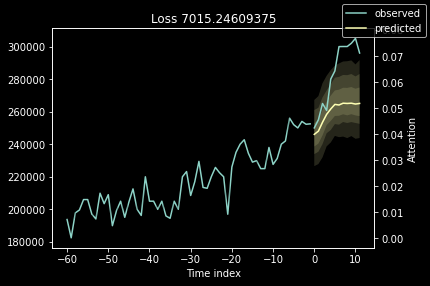

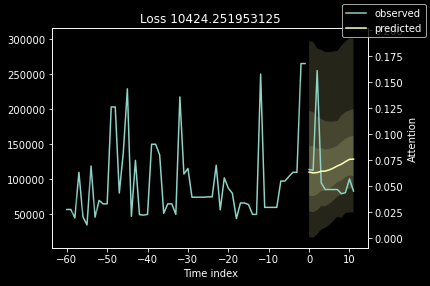

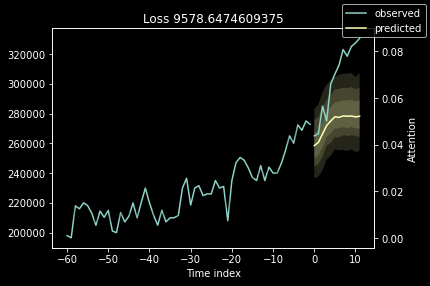

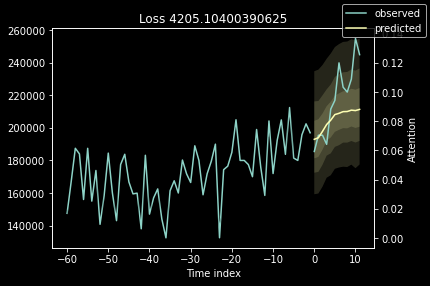

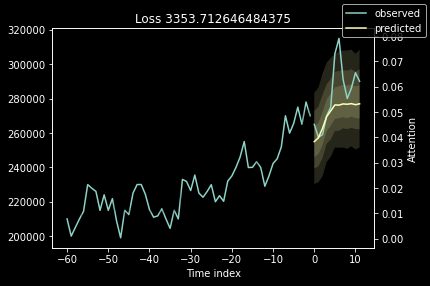

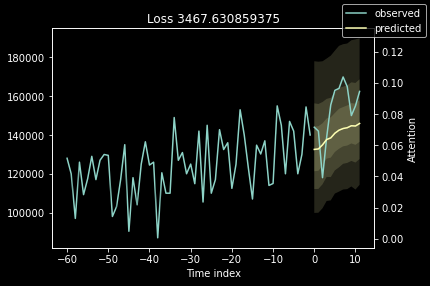

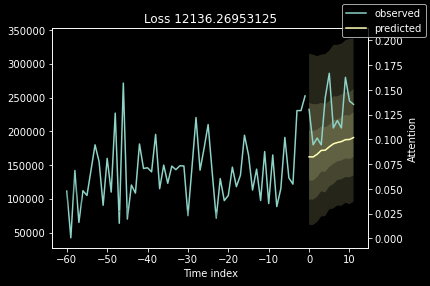

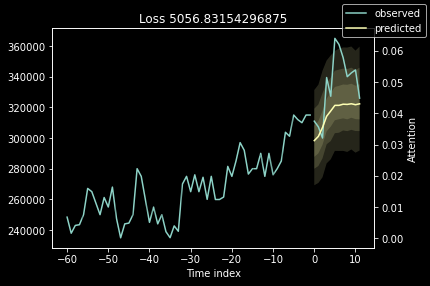

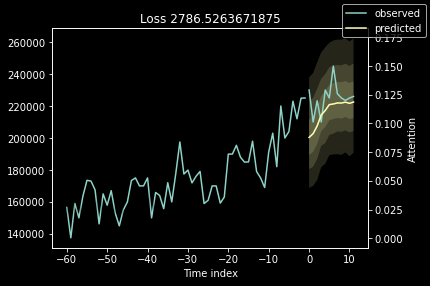

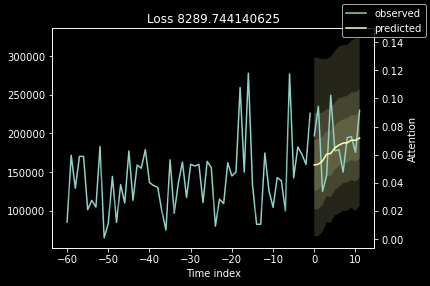

In [28]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True); #change back to best_tft

#### Worst Performers
- various metrics to choose from: https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.metrics.html#module-pytorch_forecasting.metrics

In [ ]:
# # calcualte metric by which to display
# predictions = best_tft.predict(val_dataloader)
# mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
# indices = mean_losses.argsort(descending=True)  # sort losses
# for idx in range(10):  # plot 10 examples
#     best_tft.plot_prediction(
#         x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
#     );

#### Actuals vs predictions by variable

In [ ]:
# predictions, x = best_tft.predict(val_dataloader, return_x=True)
# predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
# best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

#### Predict on selected data

In [ ]:
# change args to variables 
county = None
prop_type = None
# fips = None

In [27]:
# best_tft.predict(
#     training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
#     mode="quantiles",
# )

In [26]:
# raw_prediction, x = best_tft.predict(
#     training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
#     mode="raw",
#     return_x=True,
# )
# best_tft.plot_prediction(x, raw_prediction, idx=0);

#### Model Interpretation

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x216 with 1 Axes>,
 'encoder_variables': <Figure size 504x486 with 1 Axes>,
 'decoder_variables': <Figure size 504x288 with 1 Axes>}

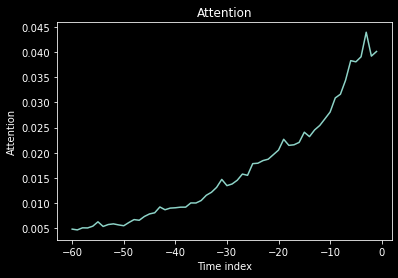

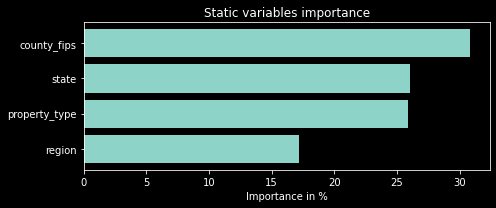

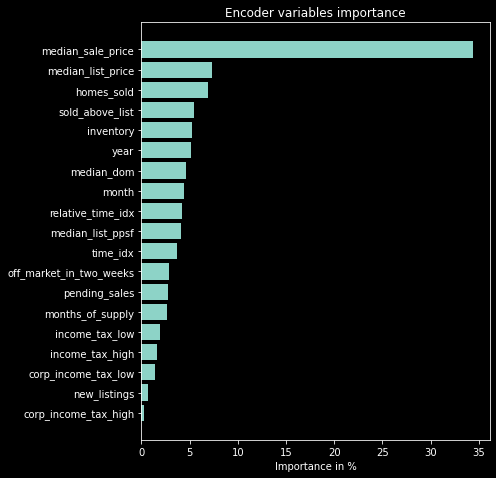

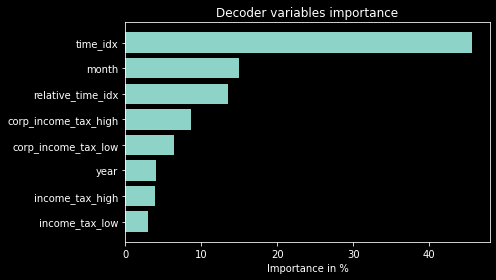

In [22]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [ ]:
 # can look at partial dependency here later